<a href="https://colab.research.google.com/github/michaelachmann/ig-tutorial/blob/main/01_DataCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Getting Started: Data Collection

This is the first in a series of jupyter notebooks taking you through all necessary steps for an Instagram analysis. 

## Getting to know Colab
Let's start using colab by mounting your google drive. Move your mouse to the left hand side of the cell below, where you can see `[ ]`, once you hover the `[ ]` a play button appears. Press the button. A few seconds later you need to confirm the connection to your drive. A new (smaller) window opens, select your account and confirm once more (scroll to the bottom of the small window).

↓

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A few seconds later the output below the cell above should read `Mounted at /content/drive`. This step is necessary, because everything in this notebook's environment is ephemeral. Once we reconnect tomorrow, all data will be gone. Hence, we write everything important to Google Drive, which ist now available at `/content/drive/MyDrive/`.

## Install instaloader
Now we are all set to install our first python package. In order to download posts and stories from Instagram, we use the package `instaloader`. You can install package for python using `pip install <package>`, the command `-q` minimizes the output. 

In [ ]:
!pip -q install instaloader

     |████████████████████████████████| 60 kB 3.0 MB/s 


Once you install instaloader we log in using your username and password. Session information (not your credentials!) is stored in Google Drive to minimize the need for signing in. 

**In order to minimize the risk for your account to be disabled we suggest creating a new account on your phone before proceeding!**



In [ ]:
#@title Logging into Instagram { display-mode: "form" }
#@markdown Please provide your username and run the cell. You will be asked to enter your password next.

username = 'your.username'  #@param {type: "string"}

#@markdown We save the sessionfile to the following directory. Default is the new folder `.instaloader` in your google drive.
session_directory = '/content/drive/MyDrive/.instaloader/' #@param {type: "string"}

import instaloader
from os.path import exists
from pathlib import Path

# Creating session directory, if it does not exists yet
Path(session_directory).mkdir(parents=True, exist_ok=True)

filename = "{}session-{}".format(session_directory, username)
sessionfile = Path(filename)


# Get instance
L = instaloader.Instaloader(compress_json=False)

# Check if sessionfile exists. If so load session,
# else login interactively
if exists(sessionfile):
  L.load_session_from_file(username, sessionfile)

else:
  L.interactive_login(username)
  L.save_session_to_file(sessionfile)


Loaded session from /content/drive/MyDrive/.instaloader/session-mi_sm_lab05.


## Downloading first Posts
Next we try to download all posts of a profile. Provide a username and folder:

In [ ]:
dest_username = 'some.profile'  #@param {type: "string"}
dest_dir = './drive/MyDrive/insta-posts/'  #@param {type: "string"}

t = Path("{}{}".format(dest_dir, dest_username))
t.mkdir(parents=True, exist_ok=True)

profile = instaloader.Profile.from_username(L.context, dest_username)
for post in profile.get_posts():
    L.download_post(post, target=t)

Well, you just downloaded your first posts! Open Google Drive and check the folder `insta-posts/` (or whatever folder you chose above)! There should be three files for each post, the image, a `.json` file and a `.txt` file. The `.txt` includes the image caption, the `.json` lots of metadata about the post. 

### Diving into the metadata 
The next cell reads all `.json` files of the downloaded posts. Then we browse through some interesting data.

In [ ]:
# Reading the paths of all JSON files from dest_dir
import os

json_files = []

for subdir, dirs, files in os.walk(t):
    for file in files:
        fullpath = os.path.join(subdir, file)
        filename, file_extension = os.path.splitext(fullpath)
        if file_extension == ".json":
          json_files.append(fullpath)

In [ ]:
# Reading all JSON files
from tqdm.notebook import tqdm
import json

json_data = []

for file in tqdm(json_files):
  with open(file, 'r') as f:
    data = json.load(f)
    json_data.append(data)

  0%|          | 0/5 [00:00<?, ?it/s]

Ok, now all metadata for all posts is saved to the variable `json_data`. Run the next line and copy its output to http://jsonviewer.stack.hu/. Your output should look similar, go ahead and play around to explore your data! What information can you extract?

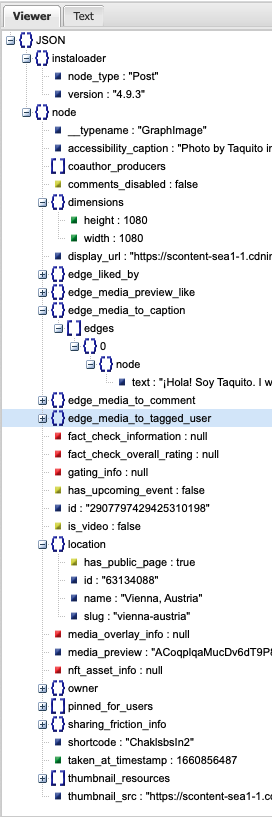

In [ ]:
print(json.dumps(json_data[0]))

### Metadata Preprocessing 
Posts contain plenty of data, like time and location of the post, the authoring user, a caption, tagged users and more.

In [ ]:
#@title What data do you want to use?
username = True #@param {type:"boolean"}
timestamp = True #@param {type:"boolean"}
caption = True #@param {type:"boolean"}
location = True #@param {type:"boolean"}
shortcode = True #@param {type:"boolean"}
id = True #@param {type:"boolean"}
tagged_users = True #@param {type:"boolean"}


Next we loop through the data and create a new [pandas](https://pandas.pydata.org/) DataFrame. The DataFrame will have one column for each variable selected above and one row for each downloaded posts. 

If you are not yet familiar with the concept of dataframes have a look at [YouTube](https://www.youtube.com/results?search_query=pandas+dataframe+basics), there's plenty of introductory videos available.

In [ ]:
import pandas as pd

posts = []  # Initializing an empty list for all posts
for post in tqdm(json_data):
  row = {} # Initializing an empty row for the post

  node = post.get("node")

  if username:
    owner = node.get("owner")
    row['username'] = owner.get("username")

  if timestamp:
    row['timestamp'] = node.get("taken_at_timestamp")

  if location:
    l = node.get("location", None)
    if l:
      row['location'] = l.get("name")

  if shortcode:
    row['shortcode'] = node.get("shortcode")

  if id:
    row['id'] = node.get("id")
  
  if tagged_users:
    pass

  if caption:
    c = ""
    emtc = node.get("edge_media_to_caption")
    edges = emtc.get("edges")
    for element in edges:
      caption_node = element.get("node")
      c = c + caption_node.get("text")
    row['caption'] = c

  # Finally add row to posts
  posts.append(row)

# After looping through all posts create data frame from list
posts_df = pd.DataFrame.from_dict(posts)

Now all information selected above is saved to the dataframe `posts_df`. Run the next cell and it will return a nicely formatted table. If your data is quite long, output will be cropped. Click the wand 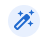 and after a few seconds you are able to browse through the data or filter by columns

In [ ]:
posts_df

In order to get a first impression of dataframes, the `head()` method is also useful. Run the next cell to see the result

In [ ]:
posts_df.head()

The dataframe is only saved in memory, thus when disconnecting and deleting the runtime, the dataframe is lost. Running the next cell saves the table to a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values)-file on your drive. 

Now the processed data may be recovered or used in another notebook.

In [ ]:
posts_df.to_csv('{}{}.csv'.format(dest_dir, username))

That's it for this notebook! Now you know how to


*   log into Instagram using `instaloader`
*   save a session
* download posts
* read the post metadata
* create a dataframe
* and save dataframes to CSV files.

See you in the next notebook!

